As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings. 

In order to do this, you planned to build a sentiment-based product recommendation system, which includes the following tasks.

1. Data sourcing and sentiment analysis
2. Building a recommendation system
3. Improving the recommendations using the sentiment analysis model
4. Deploying the end-to-end project with a user interface

The steps to be performed for the first task are given below.

- Exploratory data analysis
- Data cleaning
- Text preprocessing
- Feature extraction: In order to extract features from the text data, you may choose from any of the methods, including bag-of-words, TF-IDF vectorization or word embedding.
- Training a text classification model: You need to build at least three ML models. You then need to    analyse the performance of each of these models and choose the best model. At least three out of the following four models need to be built (Do not forget, if required, handle the class imbalance and perform hyperparameter tuning.). 
1. Logistic regression
2. Random forest
3. XGBoost
4. Naive Bayes

## 1. Data sourcing and sentiment analysis

In [1]:
## Importing all the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import pairwise_distances

# Common libraries for cleaning the text data
import string
from wordcloud import WordCloud
import re
import html
from collections import Counter
from imblearn.over_sampling import SMOTE

import unicodedata

import nltk
from nltk import pos_tag
from nltk import word_tokenize

from nltk.corpus import wordnet
from nltk.corpus import stopwords

from nltk.tokenize import WhitespaceTokenizer, word_tokenize, sent_tokenize, regexp_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

import pickle

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91987\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91987\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91987\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\91987\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Reading the provided data
reviews_df = pd.read_csv('sample30.csv')
reviews_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


#### Data Cleaning and Performing EDA

In [3]:
reviews_df.shape

(30000, 15)

In [4]:
### Total number of reviews
total = len(reviews_df['reviews_text'])
print ("Total Number of reviews: ",total)

### Number of unique reviewers
print ("Number of unique reviewers: ",len(reviews_df['reviews_username'].unique()))
unique_reviewers_proportion = float(len(reviews_df['reviews_username'].unique())/total)
print ("Proporation of unique reviewers: ",round(unique_reviewers_proportion,3))

### Average star score
print ("Average rating score: ",round(reviews_df['reviews_rating'].mean(),3))

Total Number of reviews:  30000
Number of unique reviewers:  24915
Proporation of unique reviewers:  0.831
Average rating score:  4.483


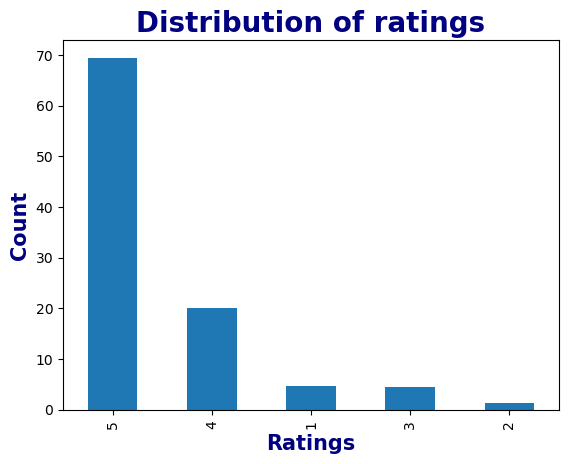

In [5]:
## Ratings distribution
percent_val = 100 * reviews_df['reviews_rating'].value_counts()/len(reviews_df)
plt.title('Distribution of ratings', fontsize=20, weight='bold', color='navy', loc='center')
plt.xlabel('Ratings', fontsize=15, weight='bold', color='navy')
plt.ylabel('Count', fontsize=15, weight='bold', color='navy')
percent_val.plot.bar()
plt.show()

In almost 70% of the records the user has rated 5

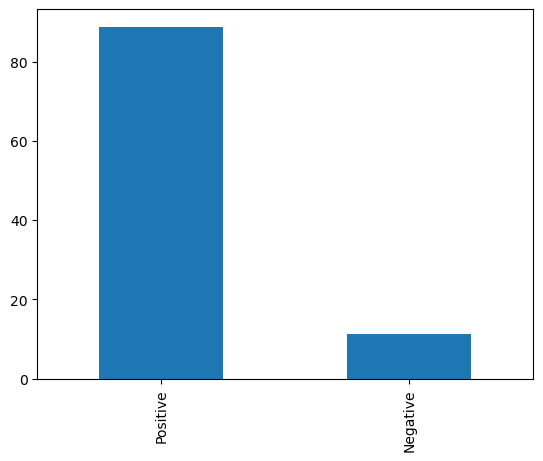

In [6]:
percent_val = 100 * reviews_df['user_sentiment'].value_counts()/len(reviews_df)
percent_val.plot.bar()
plt.show()

We need to correct the data available in the sentiments considering the rating of users

In [7]:
# Info of the dataframe 
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

c:\Users\91987\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


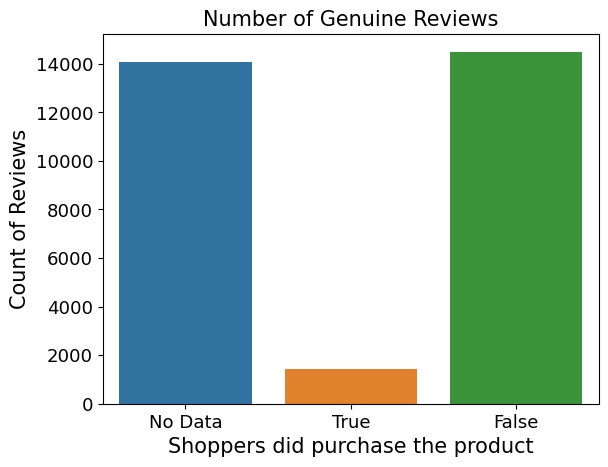

In [8]:
reviews_df['reviews_didPurchase'].fillna('No Data', inplace=True)
#Distribution of reviews for actual purchasing customers
ax = sns.countplot(reviews_df['reviews_didPurchase'])
ax.set_xlabel(xlabel="Shoppers did purchase the product", fontsize=15)
ax.set_ylabel(ylabel='Count of Reviews', fontsize=15)
ax.axes.set_title('Number of Genuine Reviews', fontsize=15)
ax.tick_params(labelsize=13)

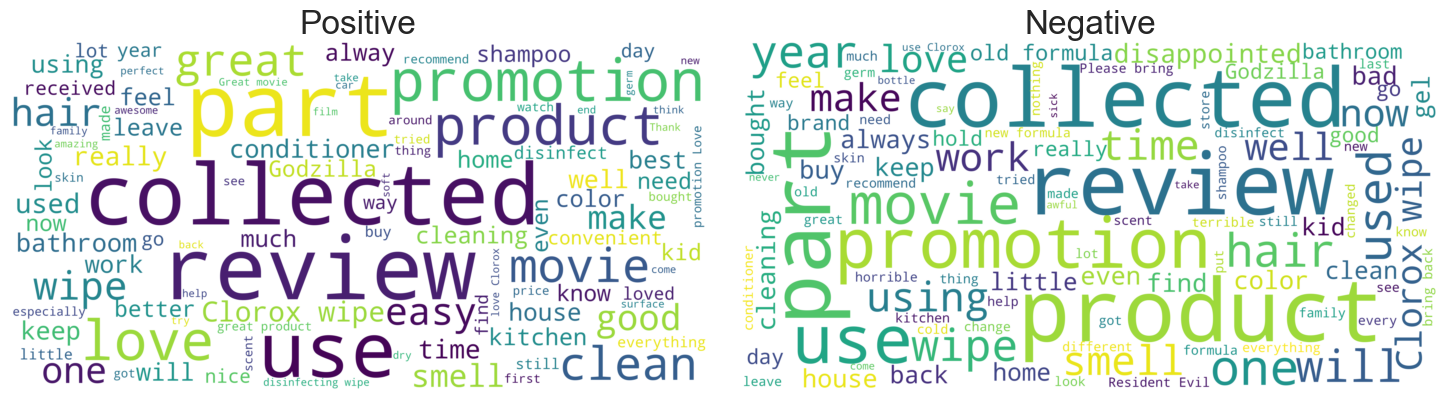

In [9]:
# Word clouds for postive and negative reviews

sns.set(font_scale=2)
plt.figure(figsize = (15,10))

plt.subplot(1, 2, 1)
plt.title('Positive')
positive_reviews=reviews_df.loc[reviews_df.user_sentiment=='Positive',['reviews_text']]
word_cloud_text = ''.join(positive_reviews['reviews_text'])
wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.imshow(wordcloud,
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.tight_layout()


plt.subplot(1, 2, 2)
plt.title('Negative')
negative_reviews=reviews_df.loc[reviews_df.user_sentiment=='Negative',['reviews_text']]

word_cloud_text = ''.join(negative_reviews['reviews_text'])

wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.imshow(wordcloud,
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.tight_layout()

Words associated with Positive reviews are mostly - 'great', 'promotion', 'good', 'nice', 'use'

Words associated with Negative reviews are mostly - 'bad', 'horrible', 'smell', 'sick', 'nothing','awful'

Data Cleaning

In [10]:
# Finding the number of rows with Null values
reviews_df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase         0
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [11]:
## Remove columns having most of values as null reviews_userCity and reviews_userProvince
reviews_df = reviews_df.drop(columns=['reviews_userCity','reviews_userProvince'],axis=1)
reviews_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,No Data,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


In [12]:
## User sentiment column Analysis
reviews_df['user_sentiment'].value_counts()

Positive    26632
Negative     3367
Name: user_sentiment, dtype: int64

Text Preprocessing : Text lower cased , removed Special Charater and lemmatized

In [13]:

# special_characters removal
def remove_special_characters(text, remove_digits=True):
    """Remove the special Characters"""
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation_and_splchars(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_word = remove_special_characters(new_word, True)
            new_words.append(new_word)
    return new_words

stopword_list= stopwords.words('english')

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopword_list:
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = to_lowercase(words)
    words = remove_punctuation_and_splchars(words)
    words = remove_stopwords(words)
    return words

def lemmatize(words):
    lemmas = lemmatize_verbs(words)
    return lemmas

In [14]:
def normalize_and_lemmaize(input_text):
    input_text = remove_special_characters(input_text)
    words = nltk.word_tokenize(input_text)
    words = normalize(words)
    lemmas = lemmatize(words)
    return ' '.join(lemmas)

In [15]:
# Take the Review comment and user sentiment as dataframe 
reviews_sentiment_df = reviews_df[['reviews_text','user_sentiment']]
reviews_sentiment_df.head()

,reviews_text,user_sentiment
0,i love this album. it's very good. more to the...,Positive
1,Good flavor. This review was collected as part...,Positive
2,Good flavor.,Positive
3,I read through the reviews on here before look...,Negative
4,My husband bought this gel for us. The gel cau...,Negative


In [16]:
# create a new column lemmatized_review using the emmatize_text function
reviews_sentiment_df['lemmatized_text'] = reviews_sentiment_df['reviews_text'].map(lambda text: normalize_and_lemmaize(text))
reviews_df['lemmatized_text']=reviews_sentiment_df['lemmatized_text']
reviews_sentiment_df.head()

C:\Users\91987\AppData\Local\Temp\ipykernel_14368\3383720957.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_sentiment_df['lemmatized_text'] = reviews_sentiment_df['reviews_text'].map(lambda text: normalize_and_lemmaize(text))


,reviews_text,user_sentiment,lemmatized_text
0,i love this album. it's very good. more to the...,Positive,love album good hip hop side current pop sound...
1,Good flavor. This review was collected as part...,Positive,good flavor review collect part promotion
2,Good flavor.,Positive,good flavor
3,I read through the reviews on here before look...,Negative,read review look buy one couple lubricants ult...
4,My husband bought this gel for us. The gel cau...,Negative,husband buy gel us gel cause irritation felt l...


In [17]:
# nupdate dataframe with lemmatized text and user sentiment 
reviews_sentiment_df = reviews_sentiment_df[['lemmatized_text','user_sentiment']]
reviews_sentiment_df

,lemmatized_text,user_sentiment
0,love album good hip hop side current pop sound...,Positive
1,good flavor review collect part promotion,Positive
2,good flavor,Positive
3,read review look buy one couple lubricants ult...,Negative
4,husband buy gel us gel cause irritation felt l...,Negative
...,...,...
29995,get conditioner influenster try im love far oi...,Positive
29996,love receive review purpose influenster leave ...,Positive
29997,first love smell product wash hair smooth easy...,Positive
29998,receive influenster never go back anything els...,Positive


In [18]:
reviews_sentiment_df['user_sentiment'].value_counts()

Positive    26632
Negative     3367
Name: user_sentiment, dtype: int64

In [19]:
#Encode the negative and postive to 0 and 1 respectively 
reviews_sentiment_df['user_sentiment'] = np.where(reviews_sentiment_df.user_sentiment == 'Positive',1,0)
reviews_sentiment_df.head()

,lemmatized_text,user_sentiment
0,love album good hip hop side current pop sound...,1
1,good flavor review collect part promotion,1
2,good flavor,1
3,read review look buy one couple lubricants ult...,0
4,husband buy gel us gel cause irritation felt l...,0


In [20]:
reviews_sentiment_df['user_sentiment'].value_counts()

1    26632
0     3368
Name: user_sentiment, dtype: int64

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_counts = TfidfVectorizer(tokenizer= word_tokenize, # type of tokenization
                               stop_words=stopwords.words('english'), # List of stopwords
                               ngram_range=(1,1)) # number of n-grams

tfidf_data = tfidf_counts.fit_transform(reviews_sentiment_df["lemmatized_text"])

c:\Users\91987\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


Feature Extraction using Count Vectorizer and TFIDF Transformer

In [22]:
#creating the pickle for countvectorizer and TFIDF Transformer
#pickle.dump(count_vect,open('count_vector_sentiment_review.pkl','wb'))
#pickle.dump(tfidf_transformer,open('tfidf_transformer_sentiment_review.pkl','wb'))
# Saving the vectorizer so that it can be used later while deploying the model

# Save to file in the current working directory
pkl_filename = "Tfidf_vectorizer_sentiment_review.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(tfidf_counts, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickled_tfidf_vectorizer = pickle.load(file)

In [23]:
# Splitting the data into train and test
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_data,
                                                                            reviews_sentiment_df['user_sentiment'],
                                                                            test_size = 0.2,
                                                                            random_state = 0)

In [24]:
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)
print(y_train_tfidf.shape)
print(y_test_tfidf.shape)

(24000, 17108)
(6000, 17108)
(24000,)
(6000,)


Now we will build 4 different ML models to predict sentiment based on title and text of the reviews

**1. Logistic Regression model**

In [25]:
# Function for Metrics
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,f1_score,precision_score,accuracy_score
performance=[]

def model_metrics(y,y_pred,model_name,metrics):
  Accuracy = accuracy_score(y,y_pred)
  roc = roc_auc_score(y,y_pred)
  confusion = confusion_matrix(y,y_pred)
  precision = precision_score(y,y_pred)
  f1 = f1_score(y,y_pred)
  TP = confusion[1,1]  # true positive
  TN = confusion[0,0]  # true negatives
  FP = confusion[0,1]  # false positives
  FN = confusion[1,0]  # false negatives
  sensitivity= TP / float(TP+FN)
  specificity = TN / float(TN+FP)

  print("*"*50)
  print('Confusion Matrix =')
  print(confusion)
  print("sensitivity of the %s = %f" % (model_name,round(sensitivity,2)))
  print("specificity of the %s = %f" % (model_name,round(specificity,2)))
  print("Accuracy Score of %s = %f" % (model_name,Accuracy))
  print('ROC AUC score of %s = %f' % (model_name,roc))
  print("Report=",)
  print(classification_report(y,y_pred))
  print("*"*50)
  metrics.append(dict({'Model_name':model_name,
                       'Accuracy':Accuracy,
                       'Roc_auc_score':roc,
                       'Precision':precision,
                       'F1_score':f1}))
  return metrics

In [26]:
# Training the data using Logistic Regression model and checking the performance based on recall and precision

# logistic regression object
lr = LogisticRegression()

# train the model on train set
lr.fit(X_train_tfidf, y_train_tfidf.ravel())
  
predictions = lr.predict(X_test_tfidf)
  
# Performance metrics 
peformance = model_metrics(y_test_tfidf, predictions,'Logistic Regression',performance)

**************************************************
Confusion Matrix =
[[ 212  413]
 [  31 5344]]
sensitivity of the Logistic Regression = 0.990000
specificity of the Logistic Regression = 0.340000
Accuracy Score of Logistic Regression = 0.926000
ROC AUC score of Logistic Regression = 0.666716
Report=
              precision    recall  f1-score   support

           0       0.87      0.34      0.49       625
           1       0.93      0.99      0.96      5375

    accuracy                           0.93      6000
   macro avg       0.90      0.67      0.72      6000
weighted avg       0.92      0.93      0.91      6000

**************************************************


- We notice that Recall and Precision are quite high but the model does not classify minority class accurately
- We need to handle the issue of class imbalance, will use SMOTE technique to handle class imbalance 

In [27]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train_tfidf == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train_tfidf == 0)))

sampler = SMOTE()

sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train_tfidf, y_train_tfidf.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 21257
Before OverSampling, counts of label '0': 2743 

After OverSampling, the shape of train_X: (42514, 17108)
After OverSampling, the shape of train_y: (42514,) 

After OverSampling, counts of label '1': 21257
After OverSampling, counts of label '0': 21257


In [28]:
# logistic regression object
lr1 = LogisticRegression()

# train the model on train set
lr1.fit(X_train_res, y_train_res.ravel())
  
predictions = lr1.predict(X_test_tfidf)
  
# Performance metrics 
peformance = model_metrics(y_test_tfidf, predictions,'Logistic Regression',performance)

**************************************************
Confusion Matrix =
[[ 559   66]
 [ 496 4879]]
sensitivity of the Logistic Regression = 0.910000
specificity of the Logistic Regression = 0.890000
Accuracy Score of Logistic Regression = 0.906333
ROC AUC score of Logistic Regression = 0.901060
Report=
              precision    recall  f1-score   support

           0       0.53      0.89      0.67       625
           1       0.99      0.91      0.95      5375

    accuracy                           0.91      6000
   macro avg       0.76      0.90      0.81      6000
weighted avg       0.94      0.91      0.92      6000

**************************************************


- We notice that now Recall and Precision of minority class has increased

In [29]:
# Saving the model as it will be used later while deploying
# Save to file in the current working directory
pkl_filename = "Logistic_Reg_Sentiment_Review_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(lr1, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickled_model = pickle.load(file)

2. Random Forest Classifier

In [30]:

rf=RandomForestClassifier(n_estimators=300)
rf.fit(X_train_res,y_train_res)
y_pred_RandomForest=rf.predict(X_test_tfidf)

peformance = model_metrics(y_test_tfidf, y_pred_RandomForest,'RandomForestClassifier',performance)

**************************************************
Confusion Matrix =
[[ 378  247]
 [ 181 5194]]
sensitivity of the RandomForestClassifier = 0.970000
specificity of the RandomForestClassifier = 0.600000
Accuracy Score of RandomForestClassifier = 0.928667
ROC AUC score of RandomForestClassifier = 0.785563
Report=
              precision    recall  f1-score   support

           0       0.68      0.60      0.64       625
           1       0.95      0.97      0.96      5375

    accuracy                           0.93      6000
   macro avg       0.82      0.79      0.80      6000
weighted avg       0.93      0.93      0.93      6000

**************************************************


- Although the accuracy is high but Recall for minority class is too low (59%)
- Hyperparamter tuning needs to be done here

In [31]:
# Create the parameter grid based on the results of random search 
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [10,20,30],
    'min_samples_leaf': [100,125,150,175],
    'min_samples_split': [200,250,300],
    'n_estimators': [250,350,500], 
    'max_features': [10,15]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, scoring="recall", n_jobs = -1,verbose = 1)

In [32]:
# Fit the grid search to the data
grid_search.fit(X_train_res,y_train_res)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30], 'max_features': [10, 15],
                         'min_samples_leaf': [100, 125, 150, 175],
                         'min_samples_split': [200, 250, 300],
                         'n_estimators': [250, 350, 500]},
             scoring='recall', verbose=1)

In [33]:
print('Recall of',grid_search.best_score_,'using',grid_search.best_params_)

Recall of 0.8413700536866258 using {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 150, 'min_samples_split': 250, 'n_estimators': 350}


- Still LR Recall value is higher than what we are getting from RF

In [34]:
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=10,
                             min_samples_leaf=175, 
                             min_samples_split=200,
                             max_features=15,
                             n_estimators=500)

In [35]:
rfc.fit(X_train_res,y_train_res)

y_pred_RandomForest_HP=rfc.predict(X_test_tfidf)

peformance = model_metrics(y_test_tfidf, y_pred_RandomForest_HP,'RandomForestClassifier With Hyperparameter tuning',performance)

**************************************************
Confusion Matrix =
[[ 424  201]
 [1218 4157]]
sensitivity of the RandomForestClassifier With Hyperparameter tuning = 0.770000
specificity of the RandomForestClassifier With Hyperparameter tuning = 0.680000
Accuracy Score of RandomForestClassifier With Hyperparameter tuning = 0.763500
ROC AUC score of RandomForestClassifier With Hyperparameter tuning = 0.725898
Report=
              precision    recall  f1-score   support

           0       0.26      0.68      0.37       625
           1       0.95      0.77      0.85      5375

    accuracy                           0.76      6000
   macro avg       0.61      0.73      0.61      6000
weighted avg       0.88      0.76      0.80      6000

**************************************************


- Even After using hyperparamter tuning in Random Forest Model, precision and recall of minority class is less than the values that we got from Logistic Regression Model

3. XGBoost

In [36]:
xgc = XGBClassifier()
xgc.fit(X_train_res,y_train_res)

y_pred_xgc=xgc.predict(X_test_tfidf)

peformance = model_metrics(y_test_tfidf, y_pred_xgc,'XGBClassifier',performance)

**************************************************
Confusion Matrix =
[[ 528   97]
 [ 443 4932]]
sensitivity of the XGBClassifier = 0.920000
specificity of the XGBClassifier = 0.840000
Accuracy Score of XGBClassifier = 0.910000
ROC AUC score of XGBClassifier = 0.881191
Report=
              precision    recall  f1-score   support

           0       0.54      0.84      0.66       625
           1       0.98      0.92      0.95      5375

    accuracy                           0.91      6000
   macro avg       0.76      0.88      0.80      6000
weighted avg       0.94      0.91      0.92      6000

**************************************************


- Minority class Recall score is better than the Random Forest classifier but the best model so far is Logistic Regression model

4. Naive Bayes

In [37]:
from sklearn.naive_bayes import MultinomialNB
MNB=MultinomialNB()
MNB.fit(X_train_res,y_train_res)

y_pred_MNB=MNB.predict(X_test_tfidf)

peformance = model_metrics(y_test_tfidf, y_pred_MNB,'Naive Bayes',performance)

**************************************************
Confusion Matrix =
[[ 447  178]
 [ 671 4704]]
sensitivity of the Naive Bayes = 0.880000
specificity of the Naive Bayes = 0.720000
Accuracy Score of Naive Bayes = 0.858500
ROC AUC score of Naive Bayes = 0.795181
Report=
              precision    recall  f1-score   support

           0       0.40      0.72      0.51       625
           1       0.96      0.88      0.92      5375

    accuracy                           0.86      6000
   macro avg       0.68      0.80      0.72      6000
weighted avg       0.90      0.86      0.88      6000

**************************************************


- From the 4 different ML models to predict the sentiment based on review text, the best model is class imbalance handled Logistic Regression model since the minority class Recall score is highest for this model (89%) 
- Hence we are choosing class imbalance handled Logistic Regression model for all the future predictions and model deployment

## 2. Building a recommendation system

User and User recommedation system

Item and Item recommedation system

User and User recommedation

In [38]:
user_based_recomm_system_df= reviews_df[reviews_df['reviews_username'].isnull()== False]
user_based_recomm_system_df.reset_index(drop=True)
print(len(user_based_recomm_system_df))
user_based_recomm_system_df.head(5)

29937


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,lemmatized_text
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,No Data,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive,love album good hip hop side current pop sound...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive,good flavor review collect part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,dorothy w,Positive,good flavor
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative,read review look buy one couple lubricants ult...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative,husband buy gel us gel cause irritation felt l...


In [39]:
# Test and Train split of the dataset.
train, test = train_test_split(user_based_recomm_system_df, test_size=0.30, random_state=31)
print(train.shape)
print(test.shape)

(20955, 14)
(8982, 14)


In [40]:
# Pivot the train ratings' dataset into matrix format in which columns are products and the rows are user IDs.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(0)
print(df_pivot.shape)
df_pivot.head(5)

(18212, 255)


id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next we will create following datasets which will be used for prediction 
- Dummy train will be used later for prediction of the products which have not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction in dummy train dataset. 

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [41]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

# The products not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [42]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(1)

dummy_train.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**Cosine Similarity**

Cosine Similarity is a measurement that quantifies the similarity between two vectors

In [43]:
from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


In [44]:
user_correlation.shape

(18212, 18212)

**Prediction user user**

Doing the prediction for the users who are positively related with other users, and not with the users who are negatively related as we are interested in the users who are more similar to the current users. So, ignoring the correlation for values less than 0. 

In [45]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset). 

In [46]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 2.27348581, 2.67438178,
        0.        ],
       [0.        , 0.        , 5.50767062, ..., 1.62113773, 0.        ,
        0.        ],
       [0.        , 0.        , 5.50767062, ..., 1.62113773, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.4454354 , ..., 0.        , 0.        ,
        2.88675135],
       [0.        , 0.        , 0.4454354 , ..., 0.        , 0.        ,
        2.88675135],
       [0.        , 0.        , 0.4454354 , ..., 0.        , 0.        ,
        2.88675135]])

In [47]:
user_predicted_ratings.shape

(18212, 255)

Since we are interested only in the products not rated by the user, we will ignore the products rated by the user by making it zero. 

In [48]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.000000,12.962852,0.0,0.0,0.0,2.576839,0.000000,0.000000,...,2.315144,0.549484,0.0,2.371708,0.000000,0.0,3.20045,2.273486,2.674382,0.000000
01impala,0.0,0.0,5.507671,26.309498,0.0,0.0,0.0,0.000000,0.000000,1.766904,...,5.940376,3.851926,0.0,0.000000,1.555428,0.0,0.00000,1.621138,0.000000,0.000000
02dakota,0.0,0.0,5.507671,26.309498,0.0,0.0,0.0,0.000000,0.000000,1.766904,...,5.940376,3.851926,0.0,0.000000,1.555428,0.0,0.00000,1.621138,0.000000,0.000000
02deuce,0.0,0.0,5.507671,26.309498,0.0,0.0,0.0,0.000000,0.000000,1.766904,...,5.940376,3.851926,0.0,0.000000,1.555428,0.0,0.00000,1.621138,0.000000,0.000000
06stidriver,0.0,0.0,0.445435,14.642593,0.0,0.0,0.0,6.659009,3.535534,0.000000,...,0.000000,0.000000,0.0,3.535534,0.000000,0.0,2.09657,0.000000,0.000000,2.886751


Finding top 5 recommendation for a user

In [49]:
d = user_final_rating.loc['piggyboy420'].sort_values(ascending=False)[0:5]
d

id
AVpf3VOfilAPnD_xjpun    12.421720
AVpfPaoqLJeJML435Xk9     7.601118
AVpf4oLxLJeJML43FcxC     7.071068
AVpfRoqcLJeJML436FqG     3.535534
AVpfRTh1ilAPnD_xYic2     3.535534
Name: piggyboy420, dtype: float64

In [50]:
mapping=user_based_recomm_system_df[['id','name']]
mapping = pd.DataFrame.drop_duplicates(mapping)
mapping.head()

,id,name
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd)
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel
30,AV1d76w7vKc47QAVhCqn,"J.R. Watkins Hand Cream, Lemon Cream"
36,AV1h6gSl-jtxr-f31p40,Ambi Complexion Cleansing Bar


In [51]:
# Merging product id with mapping file to get the name of the recommended product
d = pd.merge(d,mapping, left_on='id', right_on='id', how = 'left')
d

,id,piggyboy420,name
0,AVpf3VOfilAPnD_xjpun,12.421720,Clorox Disinfecting Wipes Value Pack Scented 1...
1,AVpfPaoqLJeJML435Xk9,7.601118,Godzilla 3d Includes Digital Copy Ultraviolet ...
2,AVpf4oLxLJeJML43FcxC,7.071068,Avery174 Ready Index Contemporary Table Of Con...
3,AVpfRoqcLJeJML436FqG,3.535534,"Vicks Vaporub, Regular, 3.53oz"
4,AVpfRTh1ilAPnD_xYic2,3.535534,Planes: Fire Rescue (2 Discs) (includes Digita...


**Evaluation  User-user recommendation system**



In [52]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]

In [53]:
common.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,lemmatized_text
21169,AVpfm8yiLJeJML43AYyu,Nexxus,"Personal Care,Hair Care,Styling Gel/Lotion,Bea...",Nexxus Beauty Products,Nexxus Exxtra Gel Style Creation Sculptor,2015-04-13T00:00:00.000Z,False,False,1,What happened The old formula was one of the b...,Truly awful!,jjjj,Positive,happen old formula one best market new one tru...
8538,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2012-03-14T13:11:25.000Z,No Data,True,5,"it works great, i love the smell it keeps my h...",Love This,jygibri,Positive,work great love smell keep home disinfect grea...
18735,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2012-01-27T00:00:00.000Z,False,True,4,I love the smell that you can clean and disinf...,This product is good!,jel08,Positive,love smell clean disinfect time like use anyth...
22417,AVpfOmKwLJeJML435GM7,Clear Scalp & Hair Therapy,"Personal Care,Hair Care,Shampoo,Featured Brand...",Clear,Clear Scalp & Hair Therapy Total Care Nourishi...,2016-08-27T00:00:00.000Z,False,False,1,I have been using Clear products for over 3 ye...,Why change a good thing,elena79,Positive,use clear products years friends family know s...
19297,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2012-01-30T00:00:00.000Z,False,True,5,I love using these wipes whether at home or at...,wonderful smell,angc,Positive,love use wipe whether home school everything s...


In [54]:
# convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username',columns='id',values='reviews_rating')
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1h6Gu0glJLPUi8IjA_,...,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37f5p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50cal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18202,18203,18204,18205,18206,18207,18208,18209,18210,18211
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0,...,0.0,0.0,0.316228,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [56]:
user_correlation_df['reviews_username'] = df_pivot.index

user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18202,18203,18204,18205,18206,18207,18208,18209,18210,18211
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0,...,0.0,0.0,0.316228,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [57]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()

user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

user_correlation_df_1.shape

(1660, 18212)

In [58]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [59]:
user_correlation_df_3 = user_correlation_df_2.T

In [60]:
print(user_correlation_df_3.shape)
user_correlation_df_3.head()

(1660, 1660)


,1234,123charlie,37f5p,4cloroxl,50cal,7.87E+11,aac06002,abbey,abbi,abby,...,yesseniaw22,yeya,ygtz,yummy,zapman,zburt5,zebras,zippy,zitro,zxcsdfd
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,1.000000,0.529813,0.0,0.0,0.529813,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.374634,0.662266,0.0
123charlie,0.529813,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
37f5p,0.000000,0.000000,1.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4cloroxl,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.000000,1.0
50cal,0.529813,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [61]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[3.64230241, 3.97944605, 0.        , ..., 2.45255736, 1.65485761,
        0.        ],
       [0.        , 3.97550579, 0.        , ..., 0.77151675, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.4417261 , 1.23091491, 0.93704257, ..., 0.        , 2.20863052,
        0.        ],
       [5.        , 2.82842712, 0.        , ..., 3.086067  , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 5.        , 0.        ,
        0.        ]])

In [62]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username',columns='id',values='reviews_rating').fillna(0)
print(dummy_test.shape)

(1660, 127)


In [63]:
print(common_user_based_matrix.shape)
common_user_based_matrix.head()

(1660, 127)


id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1h6Gu0glJLPUi8IjA_,...,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37f5p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50cal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
print(dummy_test.shape)
dummy_test.head()

(1660, 127)


id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1h6Gu0glJLPUi8IjA_,...,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37f5p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50cal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)
common_user_predicted_ratings.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1h6Gu0glJLPUi8IjA_,...,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37f5p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50cal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculating the RMSE for only the products rated by user. For RMSE, normalising the rating to (1,5) range

In [66]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))
print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [67]:
common_ = common.pivot_table(index='reviews_username',columns='id',values='reviews_rating')

# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.163472012482679


RMSE for User based recommendation system is ~ 2.1

**Item based recommendation system**

In [68]:
df_pivot = train.pivot_table(
   index='reviews_username',
    columns='id',
    values='reviews_rating'
).T

df_pivot.head()

reviews_username,00sab00,01impala,02dakota,02deuce,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,...,zowie,zozo0o,zpalma,zsazsa,zt313,zuttle,zwithanx,zxcsdfd,zyiah4,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
from sklearn.metrics.pairwise import pairwise_distances

# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_pivot.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [70]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

**Prediction item-item**

In [71]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.01669612, 0.1562388 ,
        0.        ],
       [0.        , 0.        , 0.04936223, ..., 0.00558382, 0.        ,
        0.        ],
       [0.        , 0.        , 0.08227039, ..., 0.00930637, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00487392, ..., 0.        , 0.        ,
        0.02373202],
       [0.        , 0.        , 0.00487392, ..., 0.        , 0.        ,
        0.02373202],
       [0.        , 0.        , 0.00389914, ..., 0.        , 0.        ,
        0.01898561]])

In [72]:
print(item_predicted_ratings.shape)
print(dummy_train.shape)

(18212, 255)
(18212, 255)


Filtering the rating only for products not rated by the user for recommendation

In [73]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.000000,0.065120,0.0,0.0,0.0,0.026462,0.000000,0.000000,...,0.047108,0.011110,0.0,0.051585,0.000000,0.0,0.090600,0.016696,0.156239,0.000000
01impala,0.0,0.0,0.049362,0.053915,0.0,0.0,0.0,0.000000,0.000000,0.011958,...,0.048123,0.024971,0.0,0.000000,0.017536,0.0,0.000000,0.005584,0.000000,0.000000
02dakota,0.0,0.0,0.082270,0.089858,0.0,0.0,0.0,0.000000,0.000000,0.019930,...,0.080205,0.041619,0.0,0.000000,0.029226,0.0,0.000000,0.009306,0.000000,0.000000
02deuce,0.0,0.0,0.065816,0.071886,0.0,0.0,0.0,0.000000,0.000000,0.015944,...,0.064164,0.033295,0.0,0.000000,0.023381,0.0,0.000000,0.007445,0.000000,0.000000
06stidriver,0.0,0.0,0.004874,0.026054,0.0,0.0,0.0,0.018134,0.015382,0.000000,...,0.000000,0.000000,0.0,0.023567,0.000000,0.0,0.024783,0.000000,0.000000,0.023732


Finding the top 5 recommendation for the user

In [74]:
# Recommending the Top 5 products to the user.
d = item_final_rating.loc['06stidriver'].sort_values(ascending=False)[0:5]
d

id
AVpfJP1C1cnluZ0-e3Xy    0.805265
AVpfBrUZilAPnD_xTUly    0.069056
AVpe_5U_ilAPnD_xSrxG    0.059400
AVpe8q4T1cnluZ0-afct    0.048500
AVpe41TqilAPnD_xQH3d    0.044763
Name: 06stidriver, dtype: float64

In [75]:
mapping= user_based_recomm_system_df[['id','name']]
mapping = pd.DataFrame.drop_duplicates(mapping)
mapping.head()

,id,name
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd)
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel
30,AV1d76w7vKc47QAVhCqn,"J.R. Watkins Hand Cream, Lemon Cream"
36,AV1h6gSl-jtxr-f31p40,Ambi Complexion Cleansing Bar


In [76]:
d = pd.merge(d,mapping, left_on='id', right_on='id', how = 'left')
d

,id,06stidriver,name
0,AVpfJP1C1cnluZ0-e3Xy,0.805265,Clorox Disinfecting Bathroom Cleaner
1,AVpfBrUZilAPnD_xTUly,0.069056,"Coty Airspun Face Powder, Translucent Extra Co..."
2,AVpe_5U_ilAPnD_xSrxG,0.059400,Sea Gull Lighting Six Light Bath Sconce/vanity...
3,AVpe8q4T1cnluZ0-afct,0.048500,"Newman's Own Organics Licorice Twist, Black 5oz"
4,AVpe41TqilAPnD_xQH3d,0.044763,Mike Dave Need Wedding Dates (dvd + Digital)


**Evaluation item -item**

In [77]:
test.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_text', 'reviews_title', 'reviews_username', 'user_sentiment',
       'lemmatized_text'],
      dtype='object')

In [78]:
common = test[test.id.isin(train.id	)]
print(common.shape)
common.head()

(8964, 14)


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,lemmatized_text
21384,AVpfm8yiLJeJML43AYyu,Nexxus,"Personal Care,Hair Care,Styling Gel/Lotion,Bea...",Nexxus Beauty Products,Nexxus Exxtra Gel Style Creation Sculptor,2015-03-19T00:00:00.000Z,False,False,1,I bought this gel that I have been using for o...,Bad Hair Day!!!,curlyd,Positive,buy gel use years curly hair omgosh formula ch...
14483,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2015-02-16T00:00:00.000Z,False,True,5,It's prefect and convenient for a fast clean. ...,LOVE IT,prip,Positive,prefect convenient fast clean love cant live w...
21169,AVpfm8yiLJeJML43AYyu,Nexxus,"Personal Care,Hair Care,Styling Gel/Lotion,Bea...",Nexxus Beauty Products,Nexxus Exxtra Gel Style Creation Sculptor,2015-04-13T00:00:00.000Z,False,False,1,What happened The old formula was one of the b...,Truly awful!,jjjj,Positive,happen old formula one best market new one tru...
25411,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventur...",Test,Godzilla 3d Includes Digital Copy Ultraviolet ...,2014-10-19T00:00:00.000Z,No Data,True,5,"If you`ve are into monster movies, you have to...",Godzilla 2014 nuff said!!!,internetfreak69,Positive,monster movies see movie get
20351,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2012-01-26T00:00:00.000Z,False,True,5,Makes cleaning so much easier and smells great...,Love it!!,hb6851,Positive,make clean much easier smell great


In [79]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [80]:
common_item_based_matrix.shape

(203, 8348)

In [81]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,245,246,247,248,249,250,251,252,253,254
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.109146,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001556,0.0,0.0,0.0,0.0,0.0,0.0,0.006343,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [82]:
item_correlation_df['id'] = df_pivot.index
item_correlation_df.set_index('id',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,245,246,247,248,249,250,251,252,253,254
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.109146,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001556,0.0,0.0,0.0,0.0,0.0,0.0,0.006343,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [83]:
list_name = common.id.tolist()

item_correlation_df.columns = df_pivot.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

item_correlation_df_3.head()

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,...,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.109146,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01789,0.0,...,0.0,0.001556,0.0,0.0,0.0,0.0,0.0,0.006343,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [84]:
item_correlation_df_3[item_correlation_df_3<0]=0
common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
print(common_item_predicted_ratings.shape)
common_item_predicted_ratings

(203, 8348)


array([[0.        , 0.00487392, 0.00389914, ..., 0.00487392, 0.00194957,
        0.        ],
       [0.08244513, 0.02605443, 0.02084355, ..., 0.02605443, 0.01042177,
        0.07946205],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.02130943],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.21669897],
       [0.        , 0.02373202, 0.01898561, ..., 0.02373202, 0.00949281,
        0.        ]])

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train

In [85]:
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [86]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [87]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5878655077681567


Since the **RMSE for User-based recommendation system is lesser** as compared to Item-based recommendation system, hence we will select User-based recommendation system for our project

Finding top 20 recommendations for a selected user using User-based recommendation system

In [88]:
user_input = '02deuce'
recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
mapping= user_based_recomm_system_df[['id','name']]
mapping = pd.DataFrame.drop_duplicates(mapping)
recommendations = pd.merge(recommendations,mapping, left_on='id', right_on='id', how = 'left')
recommendations

,id,02deuce,name
0,AVpfRTh1ilAPnD_xYic2,115.870466,Planes: Fire Rescue (2 Discs) (includes Digita...
1,AVpe41TqilAPnD_xQH3d,111.499361,Mike Dave Need Wedding Dates (dvd + Digital)
2,AVpf0eb2LJeJML43EVSt,108.067524,The Resident Evil Collection 5 Discs (blu-Ray)
3,AVpe59io1cnluZ0-ZgDU,70.526701,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...
4,AVpf2tw1ilAPnD_xjflC,67.519722,Red (special Edition) (dvdvideo)
5,AVpf3VOfilAPnD_xjpun,63.498127,Clorox Disinfecting Wipes Value Pack Scented 1...
6,AVpfPnrU1cnluZ0-g9rL,30.295696,Stargate (ws) (ultimate Edition) (director's C...
7,AV1YGDqsGV-KLJ3adc-O,26.309498,Windex Original Glass Cleaner Refill 67.6oz (2...
8,AVpf0thK1cnluZ0-r8vR,24.874841,100:Complete First Season (blu-Ray)
9,AVpfD9xTLJeJML431ig2,24.539462,There's Something About Mary (dvd)


In [89]:
user_final_rating.to_pickle("user_final_rating.pkl")
pickled_user_final_rating = pd.read_pickle("user_final_rating.pkl")
pickled_user_final_rating

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.000000,0.0,0.000000,12.962852,0.0,0.0,0.0,2.576839,0.000000,0.000000,...,2.315144,0.549484,0.0,2.371708,0.000000,0.0,3.20045,2.273486,2.674382,0.000000
01impala,0.000000,0.0,5.507671,26.309498,0.0,0.0,0.0,0.000000,0.000000,1.766904,...,5.940376,3.851926,0.0,0.000000,1.555428,0.0,0.00000,1.621138,0.000000,0.000000
02dakota,0.000000,0.0,5.507671,26.309498,0.0,0.0,0.0,0.000000,0.000000,1.766904,...,5.940376,3.851926,0.0,0.000000,1.555428,0.0,0.00000,1.621138,0.000000,0.000000
02deuce,0.000000,0.0,5.507671,26.309498,0.0,0.0,0.0,0.000000,0.000000,1.766904,...,5.940376,3.851926,0.0,0.000000,1.555428,0.0,0.00000,1.621138,0.000000,0.000000
06stidriver,0.000000,0.0,0.445435,14.642593,0.0,0.0,0.0,6.659009,3.535534,0.000000,...,0.000000,0.000000,0.0,3.535534,0.000000,0.0,2.09657,0.000000,0.000000,2.886751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,2.309401,0.0,0.000000,12.141899,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,1.200000,1.390096,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000
zwithanx,0.000000,0.0,0.445435,14.642593,0.0,0.0,0.0,6.659009,3.535534,0.000000,...,0.000000,0.000000,0.0,3.535534,0.000000,0.0,2.09657,0.000000,0.000000,2.886751
zxcsdfd,0.000000,0.0,0.445435,14.642593,0.0,0.0,0.0,6.659009,3.535534,0.000000,...,0.000000,0.000000,0.0,3.535534,0.000000,0.0,2.09657,0.000000,0.000000,2.886751


In [90]:
# Save to file in the current working directory

mapping.to_pickle("prod_id_name_mapping.pkl")
pickled_mapping = pd.read_pickle("prod_id_name_mapping.pkl")
pickled_mapping

,id,name
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd)
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel
30,AV1d76w7vKc47QAVhCqn,"J.R. Watkins Hand Cream, Lemon Cream"
36,AV1h6gSl-jtxr-f31p40,Ambi Complexion Cleansing Bar
...,...,...
28769,AVpfv4TlilAPnD_xhjNS,Various - Red Hot Blue:Tribute To Cole Porter ...
28772,AVpfvieo1cnluZ0-qdnu,L'oreal Paris Advanced Hairstyle TXT IT Hyper-...
28795,AVpfVMhR1cnluZ0-ixY8,2017-2018 Brownline174 Duraflex 14-Month Plann...
28799,AVpfVPh3ilAPnD_xZzW9,Mrs. Meyer's Lemon Verbena Surface Scrub


In [91]:
# Save to file in the current working directory

reviews_df.to_pickle("reviews_data_all_cols.pkl")
pickled_reviews_data = pd.read_pickle("reviews_data_all_cols.pkl")
pickled_reviews_data

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,lemmatized_text
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,No Data,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive,love album good hip hop side current pop sound...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive,good flavor review collect part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,dorothy w,Positive,good flavor
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative,read review look buy one couple lubricants ult...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative,husband buy gel us gel cause irritation felt l...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-23T00:00:00.000Z,False,True,5,I got this conditioner with Influenster to try...,Softness!!,laurasnchz,Positive,get conditioner influenster try im love far oi...
29996,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-27T00:00:00.000Z,False,True,5,"I love it , I received this for review purpose...",I love it,scarlepadilla,Positive,love receive review purpose influenster leave ...
29997,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-21T00:00:00.000Z,False,True,5,First of all I love the smell of this product....,Hair is so smooth after use,liviasuexo,Positive,first love smell product wash hair smooth easy...
29998,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-11T00:00:00.000Z,False,True,5,I received this through Influenster and will n...,Perfect for my oily hair!,ktreed95,Positive,receive influenster never go back anything els...


## 3. Improving the recommendations using the sentiment analysis model

Fine-Tuning the recommendation system and recommending top 5 products to the user based on highest percentage of positive sentiments using Sentiment Analysis model developed earlier

In [92]:
reviews_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,lemmatized_text
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,No Data,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive,love album good hip hop side current pop sound...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive,good flavor review collect part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,dorothy w,Positive,good flavor
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative,read review look buy one couple lubricants ult...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative,husband buy gel us gel cause irritation felt l...


In [93]:
# Predicting sentiment for the recommended products using the Logistic Regression model developed earlier

improved_recommendations= pd.merge(recommendations,pickled_reviews_data[['id','lemmatized_text']], left_on='id', right_on='id', how = 'left')
test_data_for_user = pickled_tfidf_vectorizer.transform(improved_recommendations['lemmatized_text'])
sentiment_prediction_for_user= pickled_model.predict(test_data_for_user)
sentiment_prediction_for_user = pd.DataFrame(sentiment_prediction_for_user, columns=['Predicted_Sentiment'])
improved_recommendations= pd.concat([improved_recommendations, sentiment_prediction_for_user], axis=1)

c:\Users\91987\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [94]:
# For each of the 20 recommended products, calculating the percentage of positive sentiments 
#   for all the reviews of each product

a=improved_recommendations.groupby('id')
b=pd.DataFrame(a['Predicted_Sentiment'].count()).reset_index()
b.columns = ['id', 'Total_reviews']
c=pd.DataFrame(a['Predicted_Sentiment'].sum()).reset_index()
c.columns = ['id', 'Total_predicted_positive_reviews']
improved_recommendations_final=pd.merge( b, c, left_on='id', right_on='id', how='left')
improved_recommendations_final['Positive_sentiment_rate'] = improved_recommendations_final['Total_predicted_positive_reviews'].div(improved_recommendations_final['Total_reviews']).replace(np.inf, 0)
improved_recommendations_final= improved_recommendations_final.sort_values(by=['Positive_sentiment_rate'], ascending=False )
improved_recommendations_final=pd.merge(improved_recommendations_final, pickled_mapping, left_on='id', right_on='id', how='left')

# Filtering out the top 5 products with the highest percentage of positive review
improved_recommendations_final.head(5)

,id,Total_reviews,Total_predicted_positive_reviews,Positive_sentiment_rate,name
0,AVpf2tw1ilAPnD_xjflC,672,622,0.925595,Red (special Edition) (dvdvideo)
1,AVpf4oLxLJeJML43FcxC,313,289,0.923323,Avery174 Ready Index Contemporary Table Of Con...
2,AVpe59io1cnluZ0-ZgDU,668,613,0.917665,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...
3,AVpfPnrU1cnluZ0-g9rL,186,170,0.913978,Stargate (ws) (ultimate Edition) (director's C...
4,AVpe9W4D1cnluZ0-avf0,362,319,0.881215,Hoover174 Platinum Collection153 Lightweight B...


## 4. Deploying the end-to-end project with a user interface

An end-to-end web application is deployed using Flask using class imbalance handled Logistic Regression model (Logistic_Reg_Sentiment_Review_model)

The app takes the username as input and upon pressing the submit button it recommends the top 5 products based on the username entered

All files used to deploy the model are placed at - https://github.com/reena-mahajan/sentiment_based_recommendation

Please refer below screenshots of the application running on local environemnt using Flask

![alt text](image.png)

![alt text](image-1.png)